In [1]:

import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
# import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
from climate_invariant import *
from tensorflow.keras import layers
import datetime


### Dividing Network with respect to the sign of bflx

### DataGenerators

In [2]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)


In [76]:
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

In [77]:
scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [78]:
train_gen = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=2048,
    shuffle=True,
    normalize_flag=True
)

In [79]:
valid_gen = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=2048,
    shuffle=True,
    normalize_flag=True
)

### Generators using RH Inputs

In [ ]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [ ]:
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

In [ ]:
in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [ ]:
TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [ ]:
train_gen_RH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=2048,
    shuffle=True,
    normalize_flag=False
)

### Generators using T-TNS Inputs

In [6]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [7]:
TRAINFILE_TNS = 'CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [8]:
train_gen_TNS = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=2048,
    shuffle=True,
    normalize_flag=False
)

NameError: name 'TRAINDIR' is not defined

### Building the Network

In [19]:

def bflx(inp):
    '''
    Returns buoyancy flux from sensible heat flux (shf), 
    latent heaf flux (lhf)
    and near-surface temperature (tns)
    '''
    cpair = 1.00464e3
    latvap = 2.501e6
    shf = inp[:,62]
    lhf = inp[:,63]
    tns = inp[:,59]
    return shf/cpair+0.61*tns*lhf/latvap

##get the bflux
def split_on_bf(inp):
    bflx_val = bflx(inp)
    mask = bflx_val > 0
    negate_mask = tf.math.logical_not(mask)
    nn1_inp = tf.boolean_mask(inp,mask)
    nn2_inp = tf.boolean_mask(inp,negate_mask)
    return mask, nn1_inp, nn2_inp


def convert_indexed_slices_to_tensor(idx_slices):
    return tf.scatter_nd(tf.expand_dims(idx_slices.indices, 1),
                         idx_slices.values, idx_slices.dense_shape)


@tf.function
def gather(x, ind):
    return tf.gather(x + 0, ind)

@tf.custom_gradient
def gather_dense_gradient(out_p, out_n):
    def grad(ys):
        return tf.scatter_nd(tf.expand_dims(idx_slices.indices, 1),
                         idx_slices.values, idx_slices.dense_shape), None
    return tf.keras.backend.concatenate((out_p, out_n),axis=0), grad

In [20]:
class FilterBflx(layers.Layer):
    def __init__(self,inp_subQ, inp_divQ,**kwargs):
        self.inp_subQ, self.inp_divQ = np.array(inp_subQ), np.array(inp_divQ)
        self.TNS_idx = 59
        self.SHFLX_idx = 62
        self.LHFLX_idx = 63
        self.cpair = 1.00464e3
        self.latvap = 2.501e6
        super(FilterBflx,self).__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)
        
    def get_config(self):
        config = {'inp_subQ': list(self.inp_subQ), 'inp_divQ': list(self.inp_divQ)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, Inp):
        #denormalize 
        shf = Inp[:,self.SHFLX_idx]*self.inp_divQ[self.SHFLX_idx]+self.inp_subQ[self.SHFLX_idx]
        lhf = Inp[:,self.LHFLX_idx]*self.inp_divQ[self.LHFLX_idx]+self.inp_subQ[self.LHFLX_idx]
        tns = Inp[:,self.TNS_idx]*self.inp_divQ[self.TNS_idx]+self.inp_subQ[self.TNS_idx]
        
        bflx_vals = shf/self.cpair+0.61*tns*lhf/self.latvap
        
        mask = bflx_vals > 0
        negate_mask = tf.math.logical_not(mask)
        
        return [mask,negate_mask]
    
    def compute_output_shape(self,inp_shape):
        return [(input_shape[0],), (input_shape[0],)]

        
        
    
       

In [21]:
class Reorder(layers.Layer):
    def __init__(self,**kwargs):
        super(Reorder,self).__init__(**kwargs)
        
        
    def get_config(self):
        base_config = super().get_config()
        return dict(list(base_config.items()))
    
    
    def call(self,inps):      
        mask,inp = inps
        i = tf.constant(0)
        curr_trues = tf.constant(0)
        n_eles = tf.size(mask)
        indices = tf.constant([], dtype=tf.int32)
        n_trues = tf.reduce_sum(tf.cast(mask, tf.int32))
        
        def cond (i,n_eles,n_trues,curr_trues,mask,indices):
            return tf.less(i,n_eles)
        
               
        def body(i,n_eles,n_trues,curr_trues,mask,indices):

            if mask[i]:
                indices_next = tf.concat([indices,tf.expand_dims(curr_trues, 0)],0)
                curr_trues = tf.add(curr_trues,1)
            else:
                indices_next = tf.concat([indices, tf.expand_dims(n_trues, 0)],0)
                n_trues = tf.add(n_trues,1)      
            i = tf.add(i,1)
            return [i,n_eles,n_trues,curr_trues,mask,indices_next]
        
        i,n_eles,n_trues,curr_trues,mask,indices = tf.while_loop(cond,body,[i,n_eles,n_trues,curr_trues,mask,indices],
                                                                shape_invariants=[
                                                                    i.get_shape(),n_eles.get_shape(),
                                                                    n_trues.get_shape(),curr_trues.get_shape(),
                                                                    mask.get_shape(),tf.TensorShape([None,])                                                        
                                                              ])
        
        return tf.keras.backend.gather(inp,indices)



In [22]:
class ReorderOpti(layers.Layer):
    def __init__(self,**kwargs):
        super(ReorderOpti,self).__init__(**kwargs)
        
        
    def get_config(self):
        base_config = super().get_config()
        return dict(list(base_config.items()))
    
    
    def call(self,inps):      
        inp,true_in,false_in = inps
        indices = tf.concat([true_in,false_in],axis=0)

        n_indices = tf.size(indices)
        partitions = tf.dynamic_partition(inp,indices,n_indices)
        
        return tf.concat(inp,indices)



In [23]:
inp = Input(shape=(64,))
mask,negate_mask = FilterBflx(inp_subQ=train_gen.input_transform.sub,
                 inp_divQ=train_gen.input_transform.div)(inp)
inpRH = QV2RH(inp_subQ=train_gen.input_transform.sub, 
              inp_divQ=train_gen.input_transform.div, 
              inp_subRH=train_gen_RH.input_transform.sub, 
              inp_divRH=train_gen_RH.input_transform.div, 
              hyam=hyam, hybm=hybm)(inp)

inpTNS = T2TmTNS(inp_subT=train_gen.input_transform.sub, 
              inp_divT=train_gen.input_transform.div, 
              inp_subTNS=train_gen_TNS.input_transform.sub, 
              inp_divTNS=train_gen_TNS.input_transform.div, 
              hyam=hyam, hybm=hybm)(inpRH)
true_indices = tf.where(mask)
false_indices = tf.where(negate_mask)
nn1_inp = tf.boolean_mask(inpTNS,mask)
nn2_inp = tf.boolean_mask(inpTNS,negate_mask)

##nn1
densout = Dense(24, activation='linear')(nn1_inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (3):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out_p = Dense(64, activation='linear')(densout)

##nn2
densout = Dense(24, activation='linear')(nn2_inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (3):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out_n = Dense(64, activation='linear')(densout)
concatenated = tf.keras.backend.concatenate((out_p, out_n),axis=0)
out = Dense(64, activation='linear')(concatenated)
# out = gather_dense_gradient(out_p,out_n)

out = Reorder()([mask,out])
# out = ReorderOpti()([out,true_indices,false_indices])
# out = gather(out,indices)
# print(indices)
print(out)
model = tf.keras.models.Model(inp, out)

Tensor("reorder_1/Identity:0", shape=(None, 64), dtype=float32)


In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
q_v2rh_1 (QV2RH)                (None, 64)           0           input_2[0][0]                    
__________________________________________________________________________________________________
t2_tm_tns_1 (T2TmTNS)           (None, 64)           0           q_v2rh_1[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_boolean_mask_2/Shap [(2,)]               0           t2_tm_tns_1[0][0]                
____________________________________________________________________________________________

In [25]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)

In [26]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_RH = ModelCheckpoint(path_HDF5+'BflxNet_Nscaling_temp.tf',save_best_only=True, monitor='val_loss', mode='min')
logdir = os.path.join("logs4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0, update_freq='batch',embeddings_freq=1)

In [ ]:
Nep = 10
model.fit_generator(train_gen,epochs=1, validation_data=valid_gen,callbacks=[earlyStopping, mcp_save_RH,tensorboard_callback])

In [27]:
### This model take around 7 hrs for 1 epoch

# Experiment Pre Split

### DataGenerators

In [89]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/BflxNetData/'
path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)


### Generator using specific inputs

In [90]:
scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

#### For Positive Bflx

In [91]:
TRAINFILE = 'Posbflx_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'Posbflx_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'Posbflx_CI_SP_M4K_valid.nc'

In [92]:
train_gen_posBflx = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

In [93]:
valid_gen_posBflx = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

In [104]:
train_gen_posBflx.input_transform.sub.shape

(64,)

#### For Negative Bflx

In [94]:
TRAINFILE = 'Negbflx_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'Negbflx_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'Negbflx_CI_SP_M4K_valid.nc'

In [95]:
train_gen_negBflx = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

In [96]:
valid_gen_negBflx = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Generators using RH Inputs

In [10]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

#### For positive bflx

In [11]:
TRAINFILE_RH = 'Posbflx_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'Posbflx_CI_RH_M4K_NORM_norm.nc'

In [12]:
train_gen_RH_posBflx = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

#### For negative bflx

In [13]:
TRAINFILE_RH = 'Negbflx_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'Negbflx_CI_RH_M4K_NORM_norm.nc'

In [14]:
train_gen_RH_negBflx = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Generators using T-TNS Inputs

In [15]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

#### For positive Bflx

In [16]:
TRAINFILE_TNS = 'Posbflx_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'Posbflx_CI_TNS_M4K_NORM_norm.nc'

In [17]:
train_gen_TNS_posBflx = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

#### For negative bflx

In [18]:
TRAINFILE_TNS = 'Negbflx_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'Negbflx_CI_TNS_M4K_NORM_norm.nc'

In [19]:
train_gen_TNS_negBflx = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Building The Network

In [30]:
class ScaleOp(layers.Layer):
    #if index = -1 that means take shflx+lhflx
    def __init__(self,index,inp_subQ, inp_divQ,**kwargs):
        self.scaling_index = index
        self.inp_subQ, self.inp_divQ =  np.array(inp_subQ), np.array(inp_divQ)
        super(ScaleOp,self).__init__(**kwargs)
        
        
    def get_config(self):
        config = {'index':self.scaling_index,'inp_subQ': list(self.inp_subQ), 'inp_divQ': list(self.inp_divQ)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    
    def call(self,inps):      
        inp,op = inps
        #for scaling using LHFLX+SHFLX
        if self.scaling_index==-1:
            scaling_factor = (inp[:,62]*self.inp_divQ[62] + self.inp_subQ[62]) + (inp[:,63]*self.inp_divQ[63] + self.inp_subQ[63])
        else:
            scaling_factor = inp[:,self.scaling_index]*self.inp_divQ[self.scaling_index] + self.inp_subQ[self.scaling_index]
        
        op_updated = op[:,:60] * tf.expand_dims(scaling_factor,1)
        op_rest = op[:,60:]
        op = tf.concat((op_updated,op_rest),axis=1)
        return op



### For Positive bflx

In [69]:
inp = Input(shape=(64,))

inpRH = QV2RH(inp_subQ=train_gen_posBflx.input_transform.sub, 
              inp_divQ=train_gen_posBflx.input_transform.div, 
              inp_subRH=train_gen_RH_posBflx.input_transform.sub, 
              inp_divRH=train_gen_RH_posBflx.input_transform.div, 
              hyam=hyam, hybm=hybm)(inp)

inpTNS = T2TmTNS(inp_subT=train_gen_posBflx.input_transform.sub, 
              inp_divT=train_gen_posBflx.input_transform.div, 
              inp_subTNS=train_gen_TNS_posBflx.input_transform.sub, 
              inp_divTNS=train_gen_TNS_posBflx.input_transform.div, 
              hyam=hyam, hybm=hybm)(inpRH)

densout = Dense(128, activation='linear')(inpTNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out = Dense(64, activation='linear')(densout)
out = ScaleOp(63,
              inp_subQ=train_gen_posBflx.input_transform.sub, 
              inp_divQ=train_gen_posBflx.input_transform.div,
              )([inp,out])
model_posBflx = tf.keras.models.Model(inp, out)

In [34]:
model_posBflx.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
q_v2rh_3 (QV2RH)                (None, 64)           0           input_4[0][0]                    
__________________________________________________________________________________________________
t2_tm_tns_3 (T2TmTNS)           (None, 64)           0           q_v2rh_3[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 128)          8320        t2_tm_tns_3[0][0]                
____________________________________________________________________________________________

In [35]:
model_posBflx.compile(tf.keras.optimizers.Adam(), loss=mse)

In [36]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/BflxNet/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_posBflx = ModelCheckpoint(path_HDF5+'Pos_LHSHSca_BflxNet.hdf5',save_best_only=True, monitor='val_loss', mode='min')
logdir = os.path.join("/oasis/scratch/comet/ankitesh/temp_project/logs/Pos_LHSHSca_BflxNetLogs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0, update_freq=1000,embeddings_freq=1)

In [37]:
Nep = 10
model_posBflx.fit_generator(train_gen_posBflx, epochs=Nep, validation_data=valid_gen_posBflx,\
              callbacks=[earlyStopping, mcp_save_posBflx,tensorboard_callback])

Epoch 1/10
  131/37833 [..............................] - ETA: 1:19:12 - loss: 4786.9430

KeyboardInterrupt: 

### For Negative bflx

In [32]:
inp = Input(shape=(64,))

inpRH = QV2RH(inp_subQ=train_gen_negBflx.input_transform.sub, 
              inp_divQ=train_gen_negBflx.input_transform.div, 
              inp_subRH=train_gen_RH_negBflx.input_transform.sub, 
              inp_divRH=train_gen_RH_negBflx.input_transform.div, 
              hyam=hyam, hybm=hybm)(inp)

inpTNS = T2TmTNS(inp_subT=train_gen_negBflx.input_transform.sub, 
              inp_divT=train_gen_negBflx.input_transform.div, 
              inp_subTNS=train_gen_TNS_negBflx.input_transform.sub, 
              inp_divTNS=train_gen_TNS_negBflx.input_transform.div, 
              hyam=hyam, hybm=hybm)(inpRH)

densout = Dense(128, activation='linear')(inpTNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out = Dense(64, activation='linear')(densout)
out = ScaleOp(-1,
              inp_subQ=train_gen_negBflx.input_transform.sub, 
              inp_divQ=train_gen_negBflx.input_transform.div,
              )([inp,out])
model_negBflx = tf.keras.models.Model(inp, out)

In [33]:
model_negBflx.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
q_v2rh_2 (QV2RH)                (None, 64)           0           input_3[0][0]                    
__________________________________________________________________________________________________
t2_tm_tns_2 (T2TmTNS)           (None, 64)           0           q_v2rh_2[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 128)          8320        t2_tm_tns_2[0][0]                
____________________________________________________________________________________________

In [34]:
model_negBflx.compile(tf.keras.optimizers.Adam(), loss=mse)

In [35]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/BflxNet/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_negBflx = ModelCheckpoint(path_HDF5+'Neg_LHSHSca_BflxNet.hdf5',save_best_only=True, monitor='val_loss', mode='min')
logdir = os.path.join("/oasis/scratch/comet/ankitesh/temp_project/logs/Neg_LHSHSca_BflxNetLogs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0, update_freq=50,embeddings_freq=1)

In [ ]:
Nep = 20
model_negBflx.fit_generator(train_gen_negBflx, epochs=Nep, validation_data=valid_gen_negBflx,\
              callbacks=[earlyStopping, mcp_save_negBflx,tensorboard_callback])

Epoch 1/20
3542/3542 [==============================] - 374s 106ms/step - loss: 433.5526 - val_loss: 263.8777
Epoch 2/20
3542/3542 [==============================] - 324s 91ms/step - loss: 243.3660 - val_loss: 220.9269
Epoch 3/20
3542/3542 [==============================] - 322s 91ms/step - loss: 216.3402 - val_loss: 207.7849
Epoch 4/20
3542/3542 [==============================] - 321s 91ms/step - loss: 204.2816 - val_loss: 193.2140
Epoch 5/20
3542/3542 [==============================] - 323s 91ms/step - loss: 197.8386 - val_loss: 186.6947
Epoch 6/20
3542/3542 [==============================] - 323s 91ms/step - loss: 190.3515 - val_loss: 182.2663
Epoch 7/20
3542/3542 [==============================] - 321s 91ms/step - loss: 186.1376 - val_loss: 181.0615
Epoch 8/20
3542/3542 [==============================] - 323s 91ms/step - loss: 181.7764 - val_loss: 176.0809
Epoch 9/20
3542/3542 [==============================] - 326s 92ms/step - loss: 179.4393 - val_loss: 179.0196
Epoch 10/20
3542/3

### Model Diganostics

In [20]:
from climate_invariant import *
import pickle
import yaml

In [170]:
def get_norm():
    
    TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/BflxNetData/'

    scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
    in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
    out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
    TRAINFILE = 'Posbflx_CI_SP_M4K_train_shuffle.nc'
    NORMFILE = 'Posbflx_CI_SP_M4K_NORM_norm.nc'

    train_gen_posBflx = DataGenerator(
        data_fn = TRAINDIR+TRAINFILE,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = TRAINDIR+NORMFILE,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        batch_size=1024,
        shuffle=True,
        normalize_flag=True
    )

    TRAINFILE = 'Negbflx_CI_SP_M4K_train_shuffle.nc'
    NORMFILE = 'Negbflx_CI_SP_M4K_NORM_norm.nc'

    train_gen_negBflx = DataGenerator(
        data_fn = TRAINDIR+TRAINFILE,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = TRAINDIR+NORMFILE,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        batch_size=1024,
        shuffle=True,
        normalize_flag=True
    )
    
    return train_gen_posBflx,train_gen_negBflx

In [171]:
#create a class tha combined the positive and negative model

In [172]:
class BflxNet:
    def __init__(self,pos_model,neg_model,dict_lay,subQ,divQ,pos_subQ,pos_divQ,neg_subQ,neg_divQ):
        self.pos_model = load_model(pos_model,custom_objects=dict_lay)
        self.neg_model = load_model(neg_model,custom_objects=dict_lay)
        self.subQ,self.divQ = np.array(subQ),np.array(divQ)
        self.pos_subQ,self.pos_divQ = np.array(pos_subQ),np.array(pos_divQ)
        self.neg_subQ,self.neg_divQ = np.array(neg_subQ),np.array(neg_divQ)
        self.cpair = 1.00464e3
        self.latvap = 2.501e6
        
    
    def bflx(self,Inp):
        shf = Inp[:,62]*self.divQ[62]+self.subQ[62]
        lhf = Inp[:,63]*self.divQ[63]+self.subQ[63]
        tns = Inp[:,59]*self.divQ[59]+self.subQ[59]
        
        bflx_vals = shf/self.cpair+0.61*tns*lhf/self.latvap
        
        mask = bflx_vals > 0
        return mask
    
    def reorder(self,op_pos,op_neg,mask):
        op = []
        pos_i=0
        neg_i = 0
        for m in mask:
            if m:
                op.append(op_pos[pos_i])
                pos_i += 1
            else:
                op.append(op_neg[neg_i])
                neg_i += 1
        return np.array(op)
                
                
    def predict_on_batch(self,inp):

        mask = self.bflx(inp)
        pos_inp = inp[mask]
        neg_inp = inp[np.logical_not(mask)]
        ##denormalize and normalize pos_inp
        pos_inp = pos_inp*self.divQ + self.subQ
        pos_inp = (pos_inp - self.pos_subQ) / self.pos_divQ
        ##denormalize and normalize neg_inp
        neg_inp = neg_inp*self.divQ + self.subQ
        neg_inp = (neg_inp - self.neg_subQ) / self.neg_divQ
        op_neg = self.neg_model.predict_on_batch(neg_inp)
        op_pos = self.pos_model.predict_on_batch(pos_inp)
        op = self.reorder(np.array(op_pos),np.array(op_neg),mask)
        return op




In [173]:
def load_combined_model(path_pos,path_neg,dict_lay,config_fn, data_fn,nlat=64, nlon=128, nlev=30, ntime=48):
    with open(config_fn, 'r') as f:
        config = yaml.load(f)
    out_scale_dict = load_pickle(config['output_dict'])
    ngeo = nlat * nlon
    train_gen = DataGenerator(
            data_fn = data_fn,
            input_vars=config['inputs'],
            output_vars=config['outputs'],
            norm_fn=config['data_dir'] + config['norm_fn'],
            input_transform=(config['input_sub'], config['input_div']),
            output_transform=out_scale_dict,
            batch_size=ngeo,
            shuffle=False,
            xarray=True,
            normalize_flag=True,
            var_cut_off=config['var_cut_off'] if 'var_cut_off' in config.keys() else None
        )
    train_gen_posBflx,train_gen_negBflx = get_norm()
    
    bflx_obj = BflxNet(path_pos,path_neg,dict_lay,train_gen.input_transform.sub,train_gen.input_transform.div,
                      train_gen_posBflx.input_transform.sub, train_gen_posBflx.input_transform.div,
                  train_gen_negBflx.input_transform.sub,train_gen_negBflx.input_transform.div)
    return bflx_obj

In [184]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/BflxNet/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc'] # Validation/test data sets
NNarray = ['CI01_RH.hdf5', 'Pos_LHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5',
          'Pos_LHSca_BflxNet.hdf5*Neg_SHSca_BflxNet.hdf5',
          'Pos_LHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5',
          'Pos_LHSHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5',
          'Pos_LHSHSca_BflxNet.hdf5*Neg_SHSca_BflxNet.hdf5',
          'Pos_LHSHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5'] # NN to evaluate
NNname = ['RH T', 'P/LH N/LH RH TNS','P/LH N/SH RH TNS','P/LH N/LHSH RH TNS',
         'P/LHSH N/LH RH TNS','P/LHSH N/SH RH TNS','P/LHSH N/LHSH RH TNS'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH, 
             'ScaleOp':ScaleOp }

In [185]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

In [186]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    if '*' not in NNs:
        NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        if '*' in NNs:
            pos_path,neg_path = NNs.split('*')
            NN[NNs] = load_combined_model(path_HDF5+pos_path,path_HDF5+neg_path,dict_lay,
                                         '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                          '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

[Errno 2] No such file or directory: '/oasis/scratch/comet/ankitesh/temp_project/PrepData/BflxNetData//HDF5_DATA'
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog
NN name is  CI01_RH.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  Pos_LHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diag

data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


NN name is  Pos_LHSca_BflxNet.hdf5*Neg_SHSca_BflxNet.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


NN name is  Pos_LHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


NN name is  Pos_LHSHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


NN name is  Pos_LHSHSca_BflxNet.hdf5*Neg_SHSca_BflxNet.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


NN name is  Pos_LHSHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [187]:
lat_ind = np.arange(26,40)
iini = 500 # Initial time to sample
iend = iini+47 # One day later

diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]] = {} # Diagnostics structure for each data file
        if i==0: diagno['truth'][data[6:-3]] = {}
        print('j=',j,'& data=',data,'         ',end='\r')
        for itime in tqdm(np.arange(iini,iend)):
            # Get input, prediction and truth from NN
            inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
            p = np.array(p)
            # Get convective heating and moistening for each NN
            if itime==iini:
                if i==0:
                    diagno['truth'][data[6:-3]]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno['truth'][data[6:-3]]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs][data[6:-3]]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs][data[6:-3]]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            else:
                for istr,field in enumerate(['PHQ','TPHYSTND']):
                    if field=='PHQ': ind_field = PHQ_idx
                    elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                    diagno[NNs][data[6:-3]][field] = np.concatenate((diagno[NNs][data[6:-3]][field],
                                                         md[NNs][data[6:-3]].\
                                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                        axis=3)
                    if i==0:
                        diagno['truth'][data[6:-3]][field] = np.concatenate((diagno['truth'][data[6:-3]][field],
                                                                 md[NNs][data[6:-3]].\
                                                                 reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                axis=3)

i= 0 & NNs= CI01_RH.hdf5          


/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



i= 1 & NNs= Pos_LHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5          



i= 2 & NNs= Pos_LHSca_BflxNet.hdf5*Neg_SHSca_BflxNet.hdf5          



i= 3 & NNs= Pos_LHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5          



i= 4 & NNs= Pos_LHSHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5          



i= 5 & NNs= Pos_LHSHSca_BflxNet.hdf5*Neg_SHSca_BflxNet.hdf5          



i= 6 & NNs= Pos_LHSHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5          


In [188]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [189]:
fz = 20
lw = 4
plt.rc('text',usetex=False)
plt.rc('font',size=fz)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']}, size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

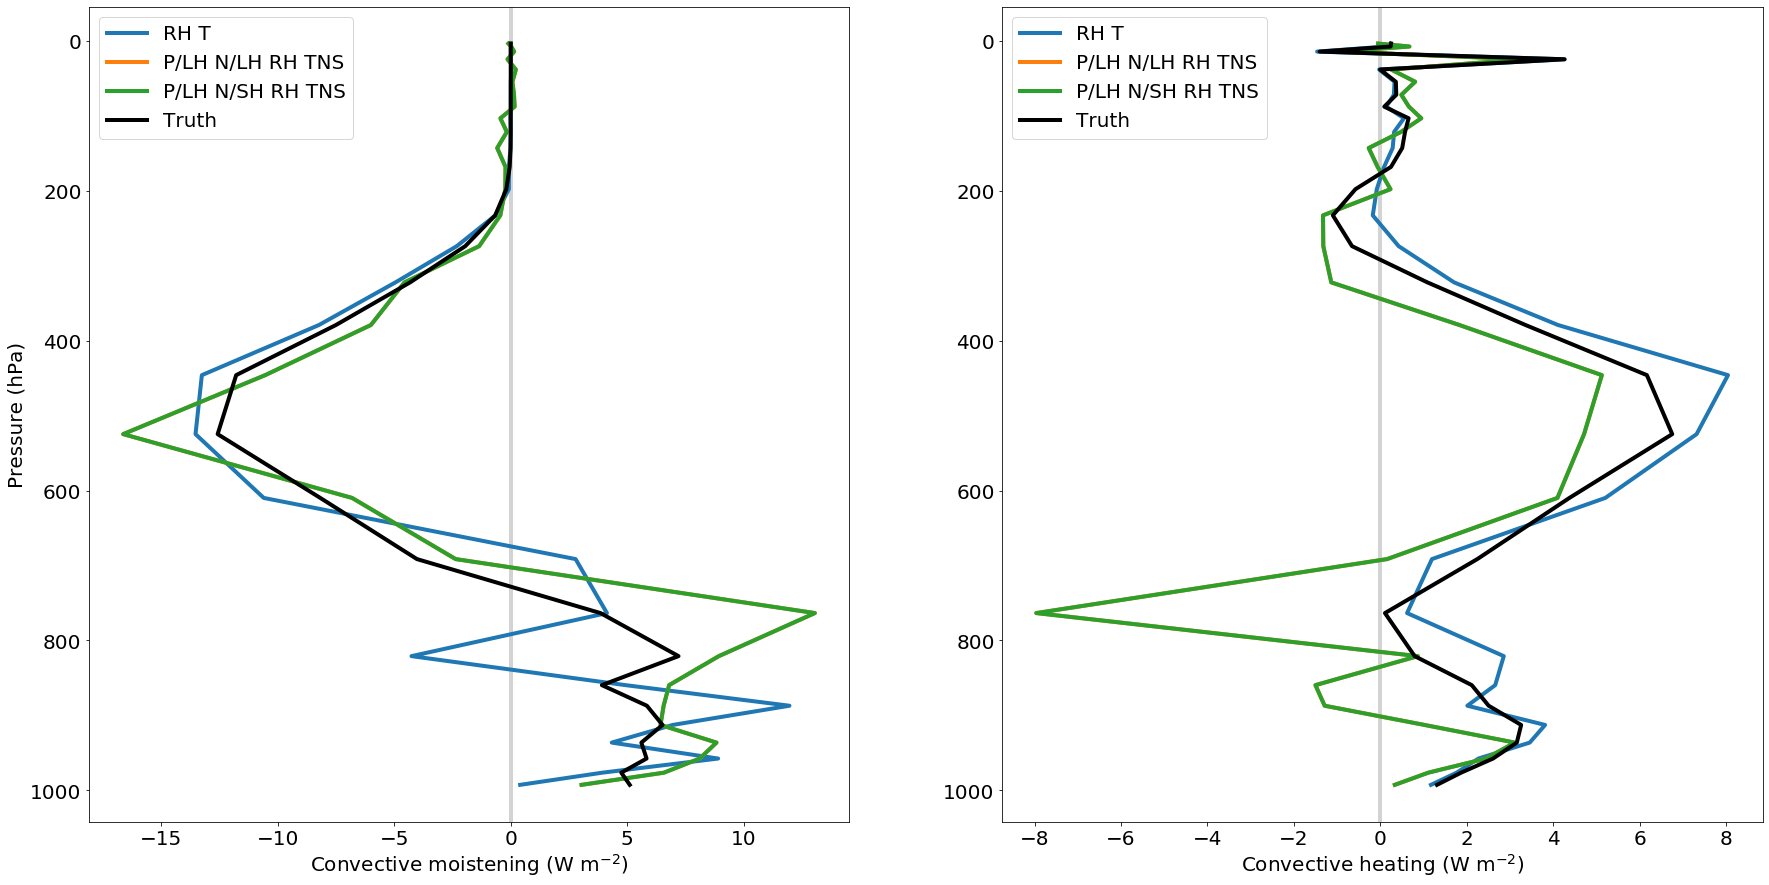

In [201]:

data = 'M4K_valid'
plt.figure(figsize=(30,15))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_RH.hdf5', 'Pos_LHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5','Pos_LHSca_BflxNet.hdf5*Neg_SHSca_BflxNet.hdf5']
NNname = ['RH T', 'P/LH N/LH RH TNS','P/LH N/SH RH TNS']
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.gca().invert_yaxis()

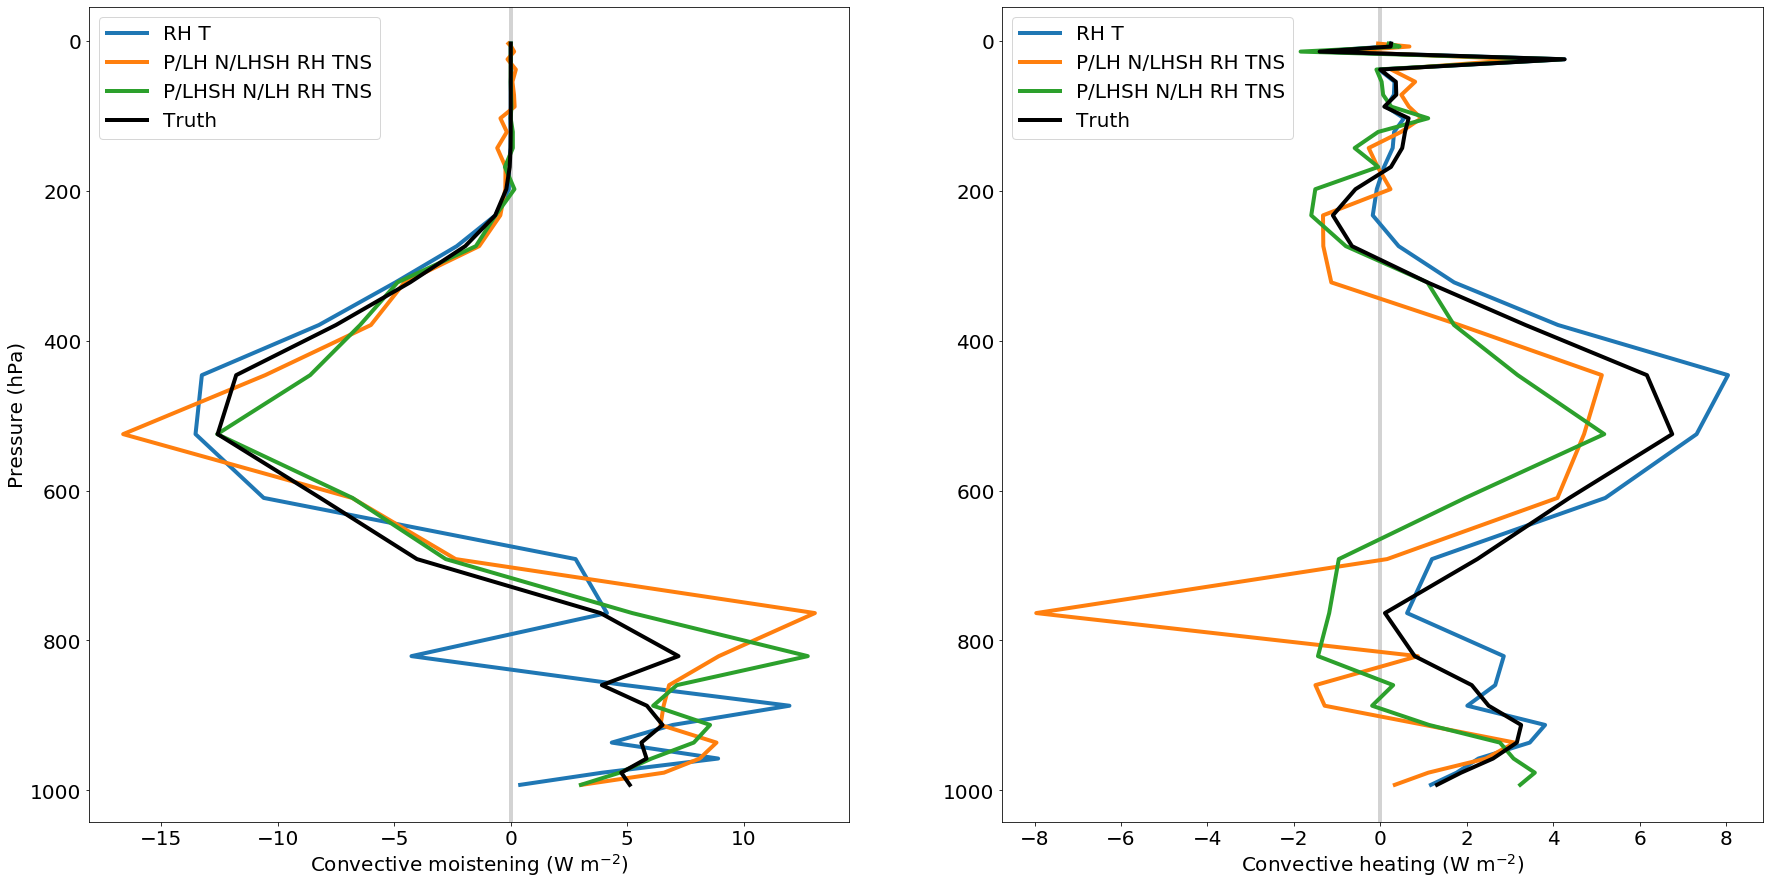

In [202]:
data = 'M4K_valid'
plt.figure(figsize=(30,15))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')

NNarray = ['CI01_RH.hdf5','Pos_LHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5','Pos_LHSHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5']
NNname = ['RH T','P/LH N/LHSH RH TNS','P/LHSH N/LH RH TNS']
for iNN,NNs in enumerate(NNarray[:3]):
    plt.plot(np.mean(diagno[NNs][data]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[:3]):
    plt.plot(np.mean(diagno[NNs][data]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.gca().invert_yaxis()

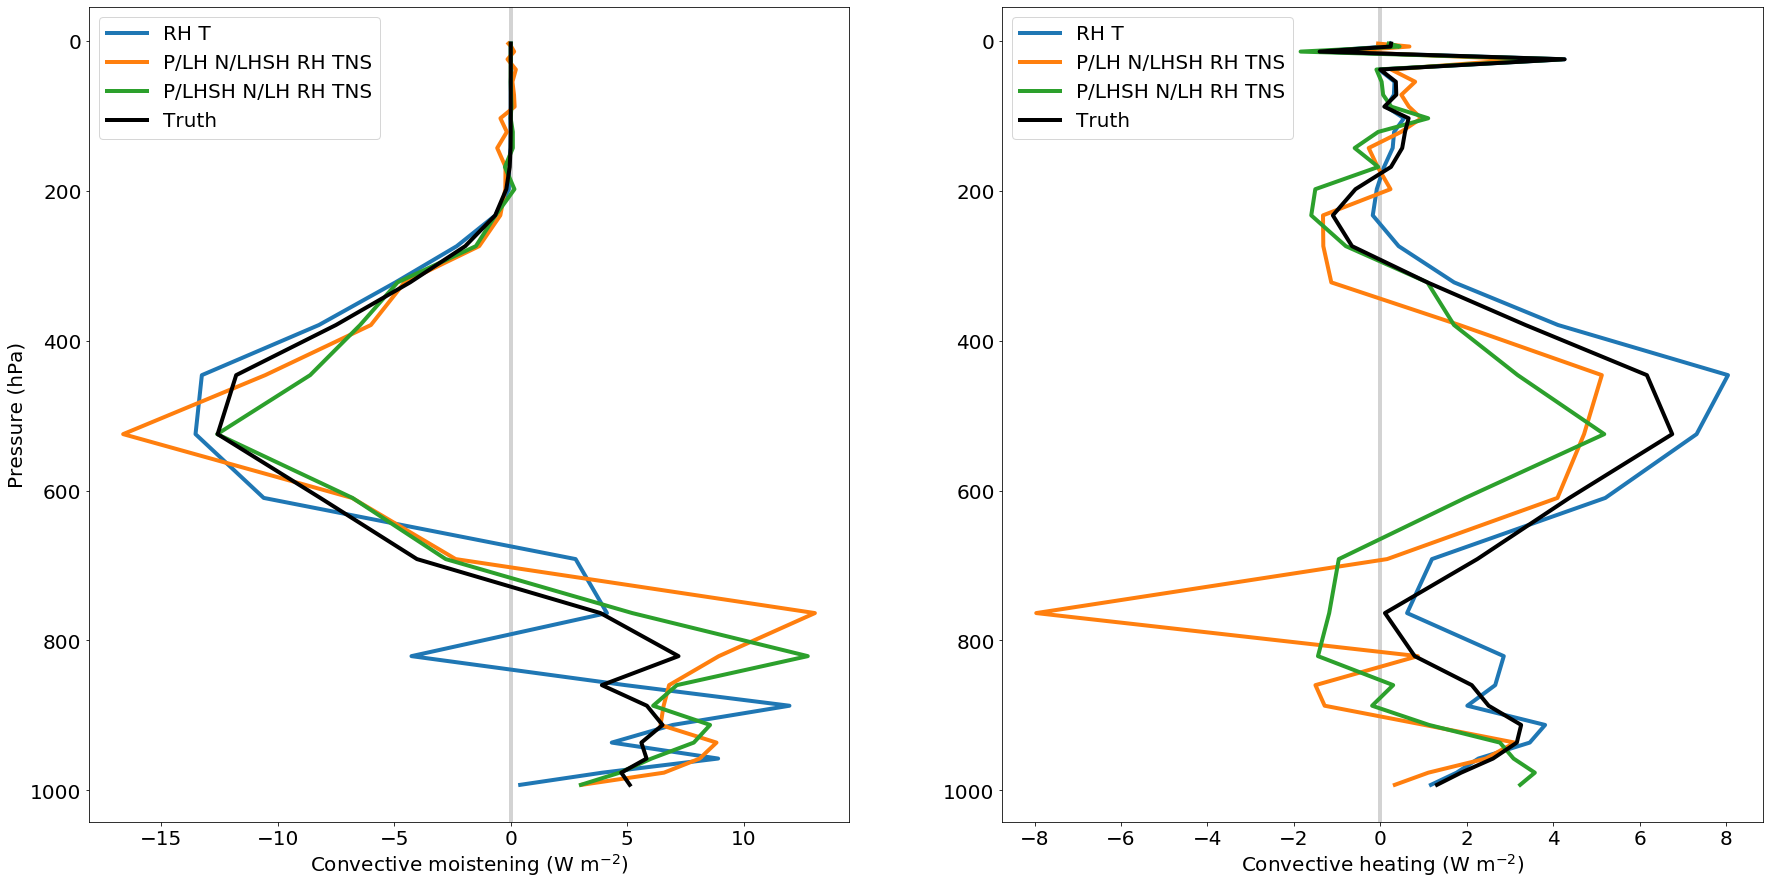

In [203]:
data = 'M4K_valid'
plt.figure(figsize=(30,15))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')

NNarray = ['CI01_RH.hdf5''Pos_LHSHSca_BflxNet.hdf5*Neg_SHSca_BflxNet.hdf5','Pos_LHSHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5']
NNname = ['RH T''P/LHSH N/SH RH TNS','P/LHSH N/LHSH RH TNS']

NNarray = ['CI01_RH.hdf5','Pos_LHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5','Pos_LHSHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5']
NNname = ['RH T','P/LH N/LHSH RH TNS','P/LHSH N/LH RH TNS']
for iNN,NNs in enumerate(NNarray[:3]):
    plt.plot(np.mean(diagno[NNs][data]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[:3]):
    plt.plot(np.mean(diagno[NNs][data]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.gca().invert_yaxis()

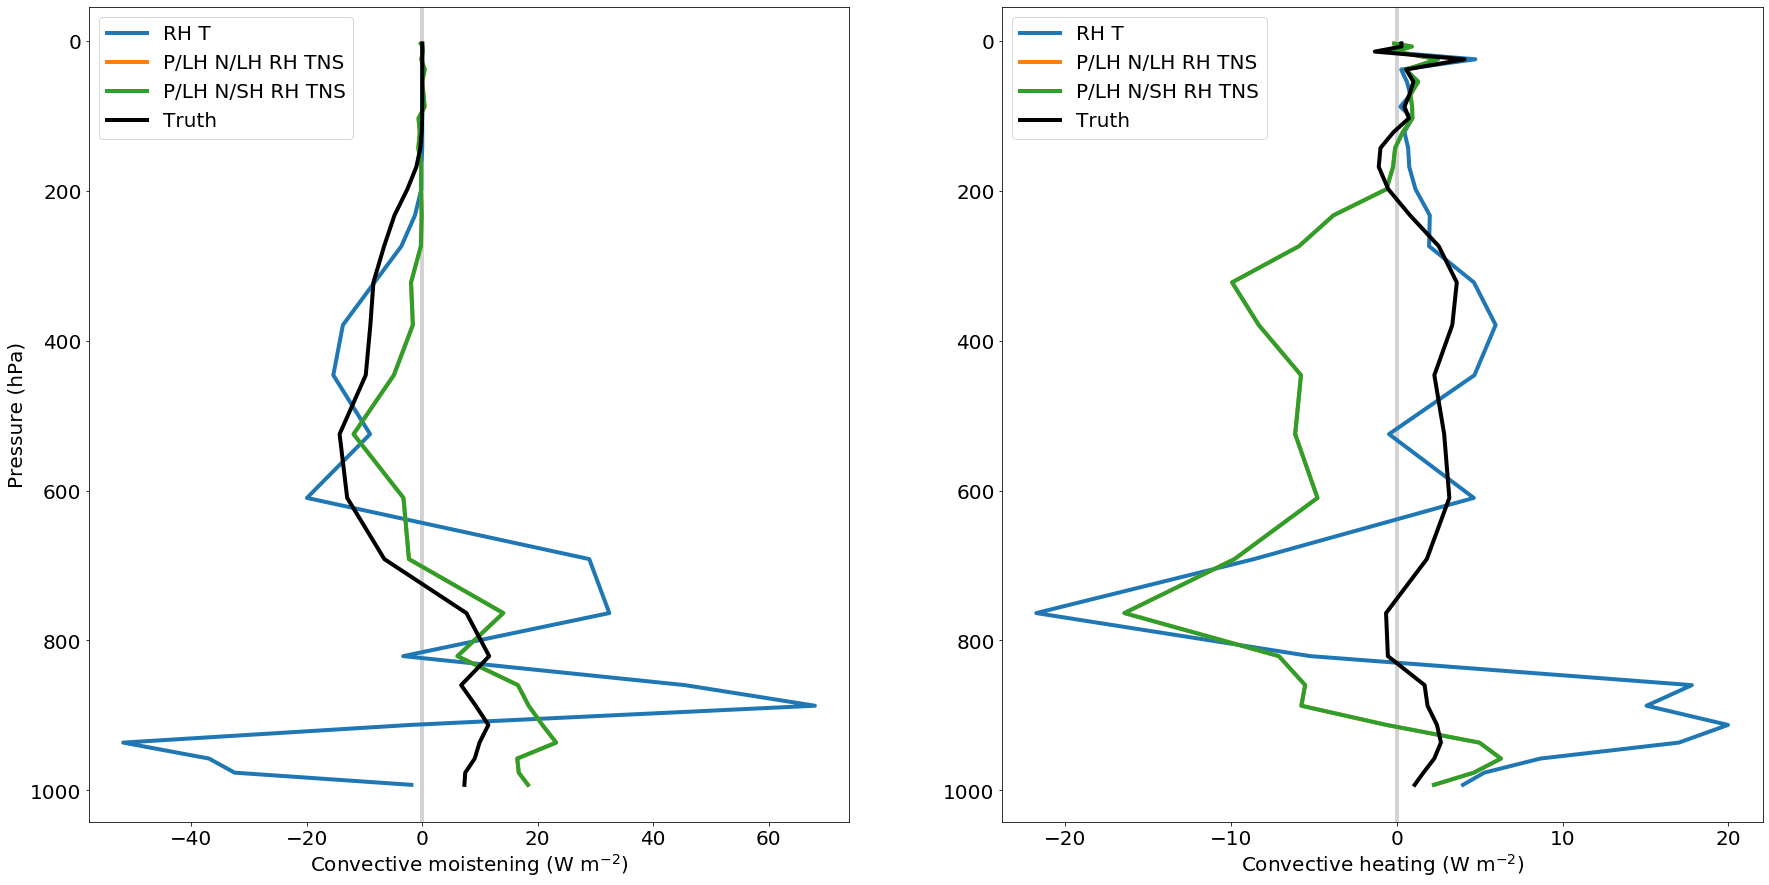

In [204]:
data = 'P4K_valid'

plt.figure(figsize=(30,15))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_RH.hdf5', 'Pos_LHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5','Pos_LHSca_BflxNet.hdf5*Neg_SHSca_BflxNet.hdf5']
NNname = ['RH T', 'P/LH N/LH RH TNS','P/LH N/SH RH TNS']
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.gca().invert_yaxis()

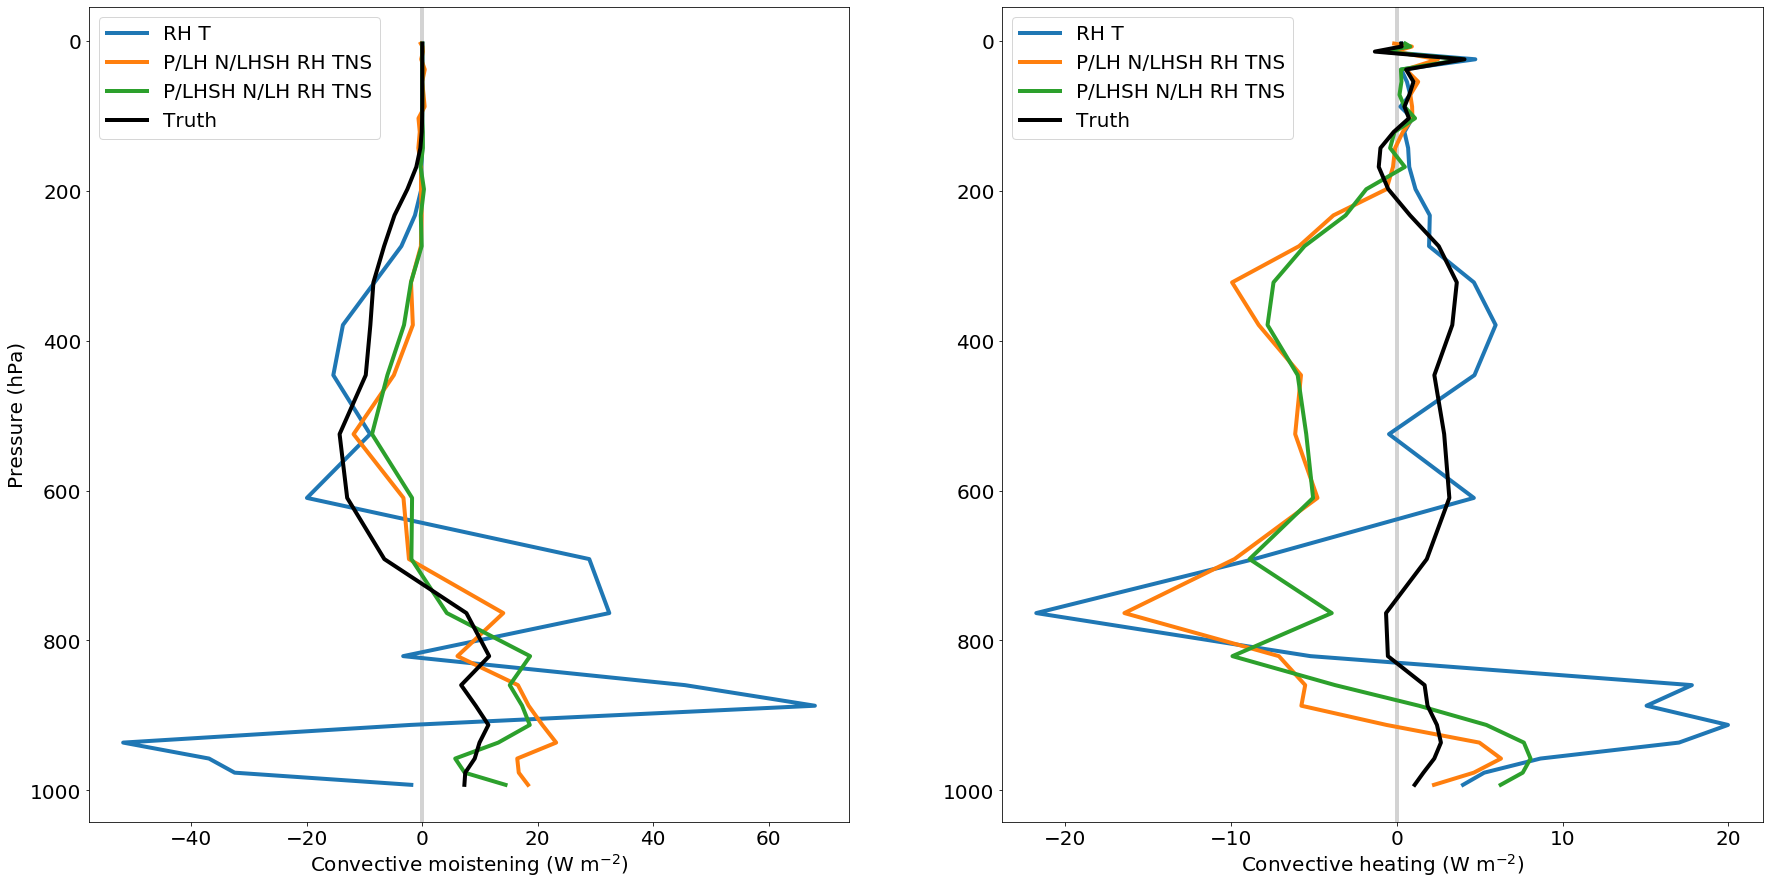

In [207]:
data = 'P4K_valid'
plt.figure(figsize=(30,15))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')

NNarray = ['CI01_RH.hdf5','Pos_LHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5','Pos_LHSHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5']
NNname = ['RH T','P/LH N/LHSH RH TNS','P/LHSH N/LH RH TNS']
for iNN,NNs in enumerate(NNarray[:3]):
    plt.plot(np.mean(diagno[NNs][data]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[:3]):
    plt.plot(np.mean(diagno[NNs][data]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.gca().invert_yaxis()

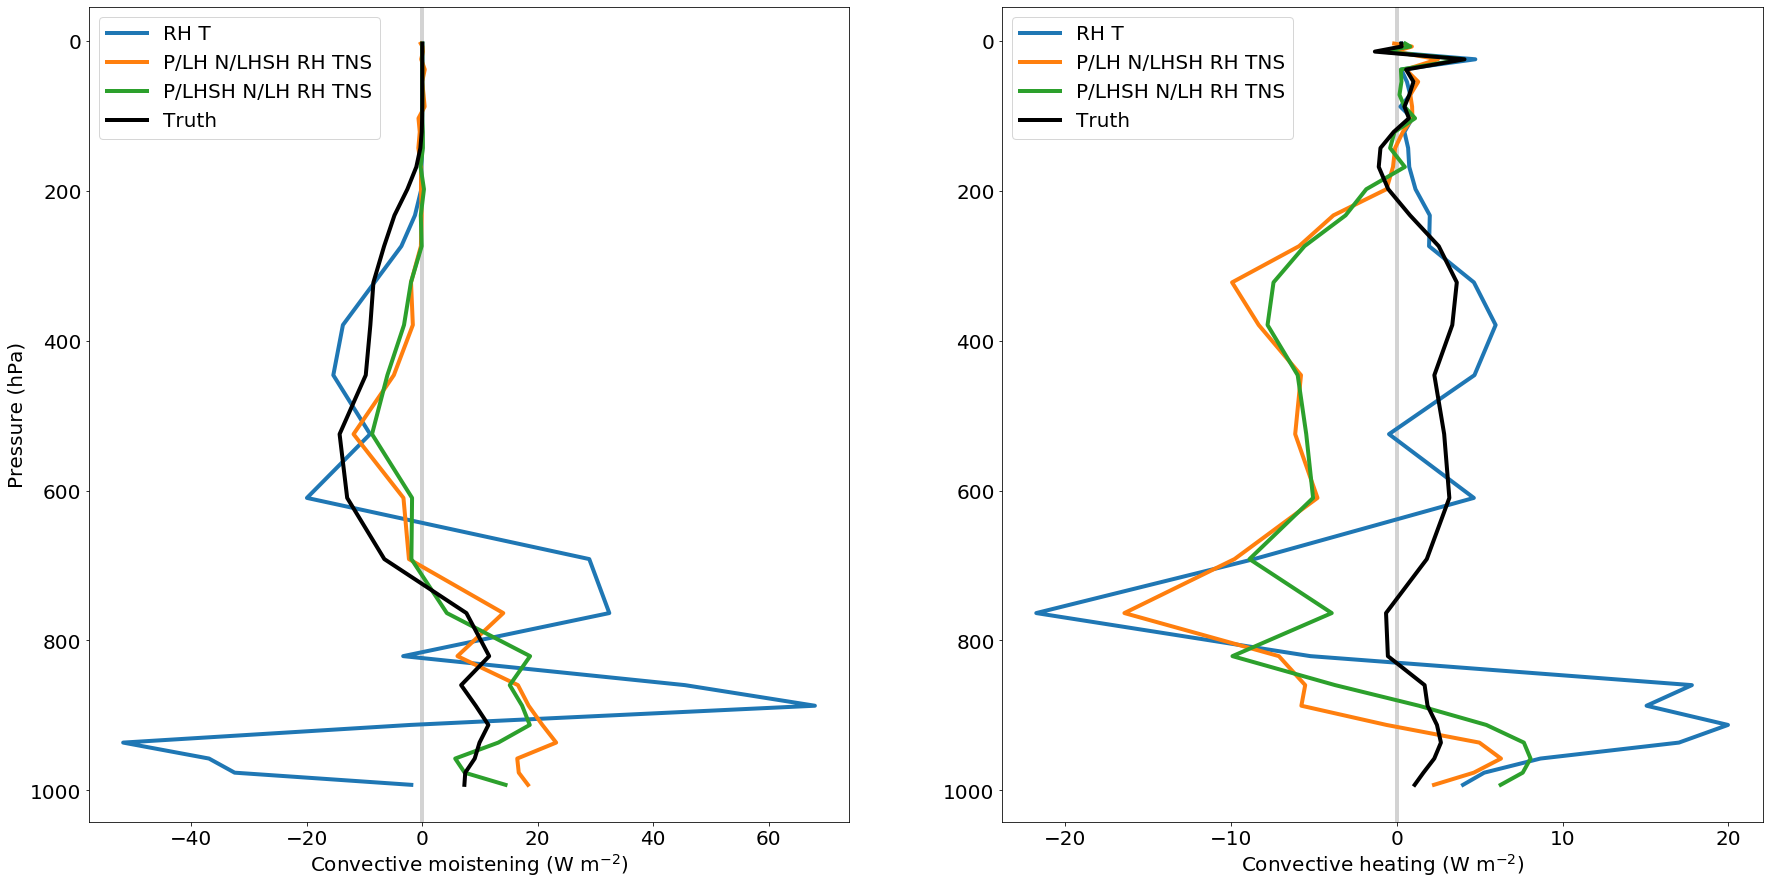

In [208]:
data = 'P4K_valid'

plt.figure(figsize=(30,15))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')

NNarray = ['CI01_RH.hdf5''Pos_LHSHSca_BflxNet.hdf5*Neg_SHSca_BflxNet.hdf5','Pos_LHSHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5']
NNname = ['RH T''P/LHSH N/SH RH TNS','P/LHSH N/LHSH RH TNS']

NNarray = ['CI01_RH.hdf5','Pos_LHSca_BflxNet.hdf5*Neg_LHSHSca_BflxNet.hdf5','Pos_LHSHSca_BflxNet.hdf5*Neg_LHSca_BflxNet.hdf5']
NNname = ['RH T','P/LH N/LHSH RH TNS','P/LHSH N/LH RH TNS']
for iNN,NNs in enumerate(NNarray[:3]):
    plt.plot(np.mean(diagno[NNs][data]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[:3]):
    plt.plot(np.mean(diagno[NNs][data]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.gca().invert_yaxis()